In [114]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
mpl.rc('figure', figsize = (12,6))
mpl.rc('font', size = 14)

In [14]:
file = 'IMDB-Movie-Data.csv'
data = pd.read_csv(file)
data.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [15]:
# Data type of each column
data.iloc[0].apply(type)

Rank                    <class 'numpy.int64'>
Title                           <class 'str'>
Genre                           <class 'str'>
Description                     <class 'str'>
Director                        <class 'str'>
Actors                          <class 'str'>
Year                    <class 'numpy.int64'>
Runtime (Minutes)       <class 'numpy.int64'>
Rating                <class 'numpy.float64'>
Votes                   <class 'numpy.int64'>
Revenue (Millions)    <class 'numpy.float64'>
Metascore             <class 'numpy.float64'>
Name: 0, dtype: object

In [50]:
#THE DATA CLEANING PROCESS
# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data.select_dtypes(include=['int64', 'float64'])), columns=data.select_dtypes(include=['int64', 'float64']).columns)
data[data_imputed.columns] = data_imputed

In [16]:
data.shape

(1000, 12)

In [17]:
# create a df of movies for which a RATING is present
movies_with_rating = data[data['Rating'].isnull() ==  False]

In [18]:
plt.style.use('fivethirtyeight')

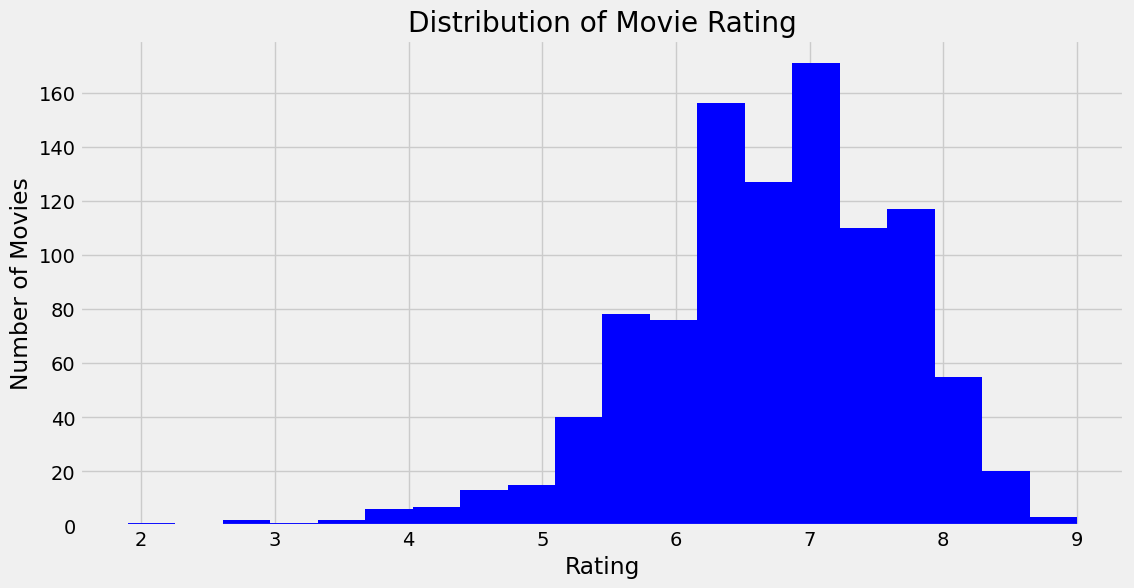

In [104]:
# plot Histogram
plt.hist(movies_with_rating['Rating'].sort_values(), bins = 20,color='Blue')
plt.title("Distribution of Movie Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Movies")
plt.show()

In [ ]:
#Distribution of ratings is negatively skewed.
#The negative slope indicated that few movies drag down mean Rating of the dataset.
#Thus, median is to be used as it gives a better avg when distrubutions are skewed.

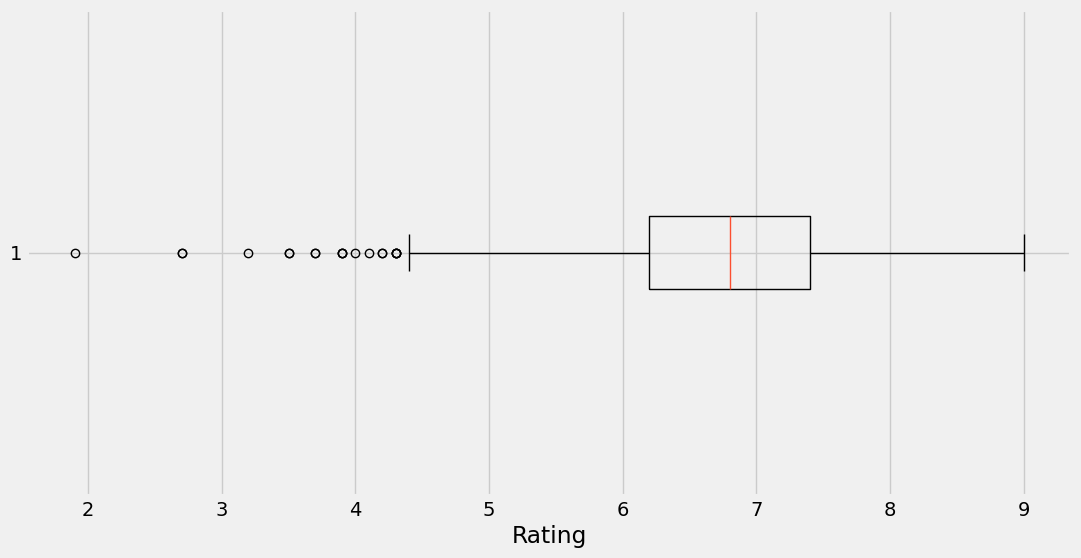

In [20]:
# Boxplot to show rante of ratings
plt.boxplot(movies_with_rating['Rating'], vert = False)
plt.xlabel('Rating')
plt.show()

In [56]:
print("Median")
a=movies_with_rating['Rating'].median()
print(a)
print("The orange line in boxplot shows the median which is 6.1 and there are no outliers.")

Median
6.8
The orange line in boxplot shows the median which is 6.1 and there are no outliers.


ANALYSING "METASCORE"

In [55]:
# Create a df of movies where Voting figure is present
movies_with_Ms = data[data['Votes'].isnull() == False]
#display number of movies having Voting count
movies_with_Ms['Votes'].count()

1000

In [61]:
movies_with_Ms['Votes'].describe()

count    1.000000e+03
mean     1.698083e+05
std      1.887626e+05
min      6.100000e+01
25%      3.630900e+04
50%      1.107990e+05
75%      2.399098e+05
max      1.791916e+06
Name: Votes, dtype: float64

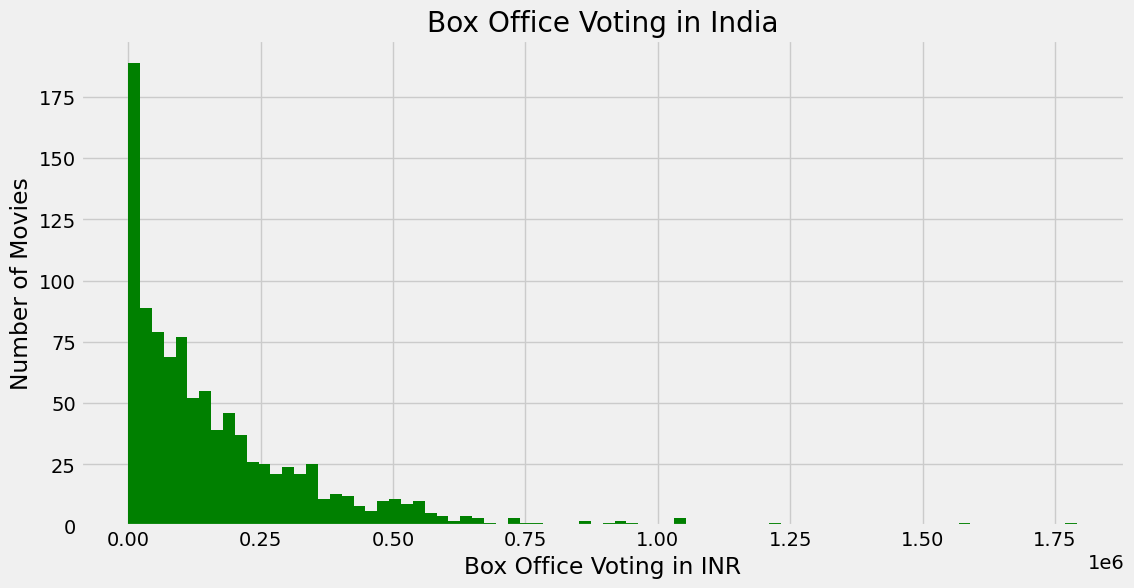

In [99]:
#plot histogram of Voting
plt.hist(movies_with_Ms['Votes'].sort_values(), bins = 80,color='green')
plt.title("Box Office Voting in India")
plt.xlabel("Box Office Voting in INR")
plt.ylabel('Number of Movies')
plt.show()

In [58]:
#Distrubution is skewed heavily towards right as very few movies have grossed beyond 6000000.
#Most of them gross in the range of 0 to 600000.

In [59]:
q1 = movies_with_Ms['Votes'].quantile(0.25)
q3 = movies_with_Ms['Votes'].quantile(0.75)
print(f' 25th percentile of the data is: {q1}, 75th percentile data is: {q3}')

 25th percentile of the data is: 36309.0, 75th percentile data is: 239909.75


In [60]:
iqr = q3 - q1
print(f'the interquartile range of the votes is: {iqr}')

the interquartile range of the votes is: 203600.75


IQR - Intquartile Range.
measure of variability, based on dividing a data set into quartiles.

The interquartile range iqr is the range of the middle 50% of the values in a data set, which is calculated as the difference between the 75th [upper quartile Q3] and 25th percentile [lower quartile Q1] values.

Mild outliers are those lower than the 25th quartile [Q1] minus 1.5 x IQR or greater than the 75th quartile [Q3] plus 1.5 x IQR.

In [62]:
outliers = movies_with_Ms.query('Votes > (@q3 + 1.5*@iqr)')
outliers.describe()

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
count,45.000000,45.000000,45.000000,45.000000,4.500000e+01,45.000000,45.000000
mean,219.266667,2010.688889,131.377778,7.968889,7.458054e+05,273.586222,73.132669
std,180.649762,2.737137,21.986865,0.490743,2.678237e+05,181.286012,11.729960
min,1.000000,2006.000000,91.000000,6.900000,5.473680e+05,13.180000,52.000000
25%,83.000000,2009.000000,116.000000,7.800000,5.708140e+05,146.410000,65.000000
50%,145.000000,2011.000000,130.000000,8.000000,6.362430e+05,233.910000,74.000000
75%,280.000000,2013.000000,148.000000,8.300000,8.556040e+05,333.130000,81.000000
max,689.000000,2016.000000,180.000000,9.000000,1.791916e+06,936.630000,96.000000


In [63]:
# Display the median value for indian voting (Outliers)
print("Median votes of all movies = {}".format(movies_with_Ms['Votes'].median()))
print("Median votes of Outliers = {}".format(outliers['Votes'].median()))
print("Ratio of mean votes = {}".format(outliers['Votes'].mean()/movies_with_Ms['Votes'].mean()))
print("Ratio of median votes = {}".format(outliers['Votes'].median()/movies_with_Ms['Votes'].median()))
print("Percentage of outliers = {}".format(outliers['Title'].count()/movies_with_Ms['Title'].count() * 100))

Median votes of all movies = 110799.0
Median votes of Outliers = 636243.0
Ratio of mean votes = 4.39204429594885
Ratio of median votes = 5.742317168927517
Percentage of outliers = 4.5


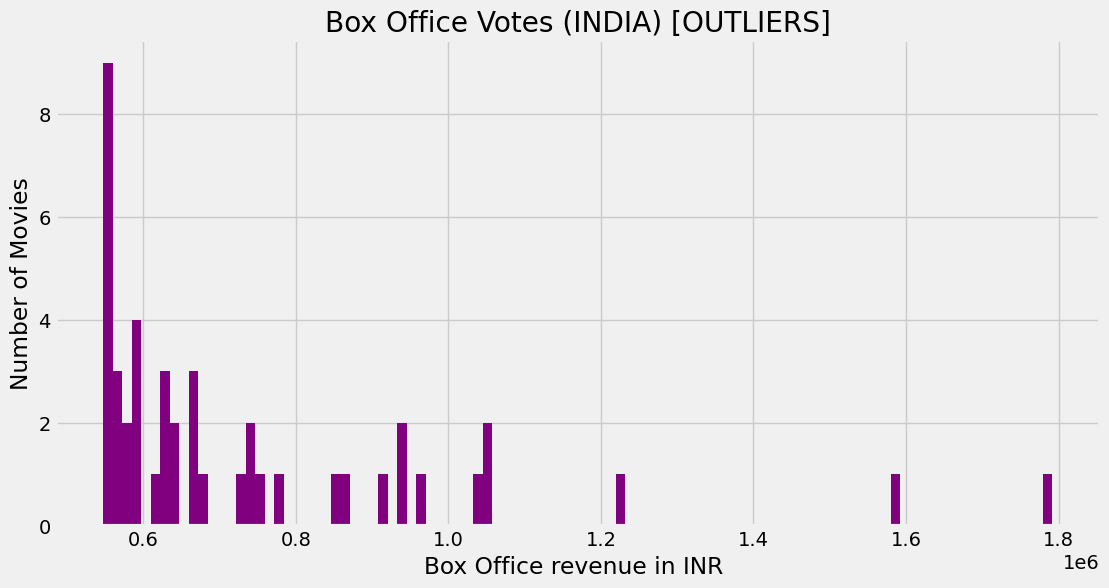

In [98]:
# Plot a histogram of Indian voting (Outliers)
plt.hist(outliers['Votes'].sort_values(), bins=100,color='purple')
plt.title("Box Office Votes (INDIA) [OUTLIERS]")
plt.xlabel("Box Office revenue in INR ")
plt.ylabel("Number of Movies")
plt.show()

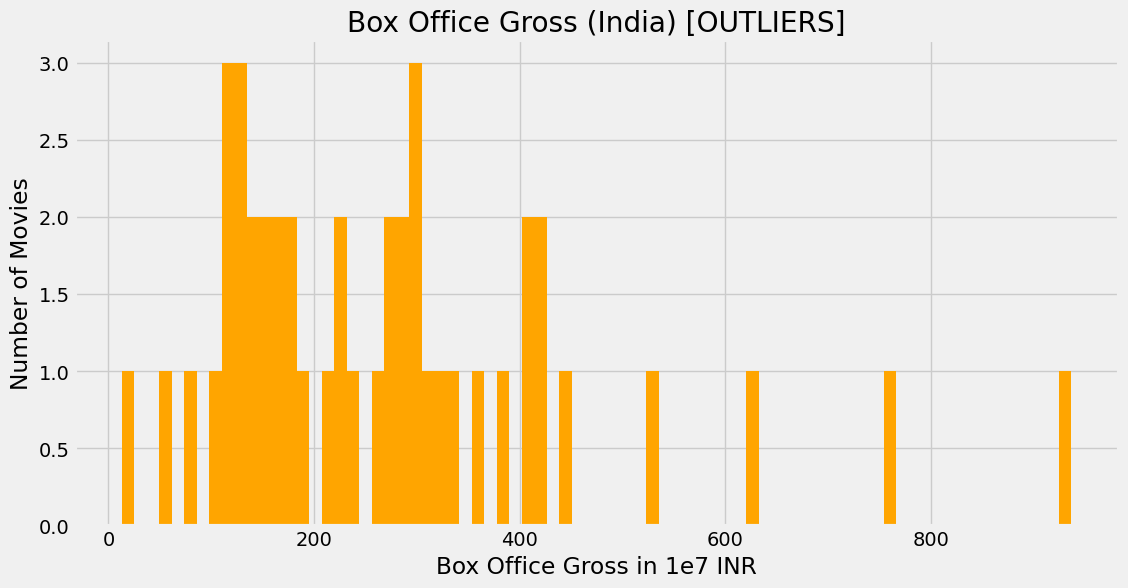

In [97]:
# Plot a histogram of Indian gross (Outliers)
plt.hist(outliers['Revenue (Millions)'].sort_values(), bins=76,color='orange')
plt.title("Box Office Gross (India) [OUTLIERS]")
plt.xlabel("Box Office Gross in 1e7 INR")
plt.ylabel("Number of Movies")
plt.show()

In [66]:
movies_with_gross_india = data[data['Revenue (Millions)'].isnull() == False ]
movies_with_gross_india['Revenue (Millions)'].describe()

count    1000.000000
mean       82.956376
std        96.412043
min         0.000000
25%        17.442500
50%        60.375000
75%        99.177500
max       936.630000
Name: Revenue (Millions), dtype: float64

In [67]:
# Outliers amongst the outliers
print("Movies which have an Indian box office gross above INR 100cr:")
high_gross_in_india = movies_with_gross_india[movies_with_gross_india['Revenue (Millions)'] > 100]
high_gross_in_india.sort_values('Revenue (Millions)', ascending=False).reset_index(inplace=True)
high_gross_in_india[['Title', 'Director', 'Actors', 'Rating', 'Revenue (Millions)']] [:10]

Movies which have an Indian box office gross above INR 100cr:


,Title,Director,Actors,Rating,Revenue (Millions)
0,Guardians of the Galaxy,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",8.1,333.13
1,Prometheus,Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",7.0,126.46
2,Split,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",7.3,138.12
3,Sing,Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",7.2,270.32
4,Suicide Squad,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",6.2,325.02
6,La La Land,Damien Chazelle,"Ryan Gosling, Emma Stone, Rosemarie DeWitt, J....",8.3,151.06
9,Passengers,Morten Tyldum,"Jennifer Lawrence, Chris Pratt, Michael Sheen,...",7.0,100.01
10,Fantastic Beasts and Where to Find Them,David Yates,"Eddie Redmayne, Katherine Waterston, Alison Su...",7.5,234.02
11,Hidden Figures,Theodore Melfi,"Taraji P. Henson, Octavia Spencer, Janelle Mon...",7.8,169.27
12,Rogue One,Gareth Edwards,"Felicity Jones, Diego Luna, Alan Tudyk, Donnie...",7.9,532.17


Most Popular Genre

In [68]:
# DF of movies for which genre is present
movies_with_genre = data[data['Genre'].isnull() == False]
data['Genre'].head()

0     Action,Adventure,Sci-Fi
1    Adventure,Mystery,Sci-Fi
2             Horror,Thriller
3     Animation,Comedy,Family
4    Action,Adventure,Fantasy
Name: Genre, dtype: object

In [69]:
# collecting the unique genres into a set
unique_genres = set()
for genre in movies_with_genre['Genre'].str.split(","):
    for g in genre:
        unique_genres.add(g)


print("Number of unique genres: {}".format(len(unique_genres)))

Number of unique genres: 20


In [70]:
#Grouping by genres
movies_by_genre = dict()
genre_masks = dict()

# Dictionary of masks
for genre in unique_genres:
    genre_masks[genre] = movies_with_genre['Genre'].apply(lambda x: genre in x)


# create dic of movies witg particular genre
for genre in unique_genres:
    movies_by_genre[genre] = movies_with_genre[genre_masks[genre]]

In [71]:
# create a dic mapping of genre and number of movies belong to that genre
count_of_movies_by_genre = dict()

for genre in unique_genres:
    count_of_movies_by_genre[genre] = movies_by_genre[genre]['Title'].count()

count_of_movies_by_genre = pd.Series(count_of_movies_by_genre).sort_values(ascending = False)
print("Number of movies in each genre")
print(count_of_movies_by_genre)

Number of movies in each genre
Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Music         21
Sport         18
War           13
Western        7
Musical        5
dtype: int64


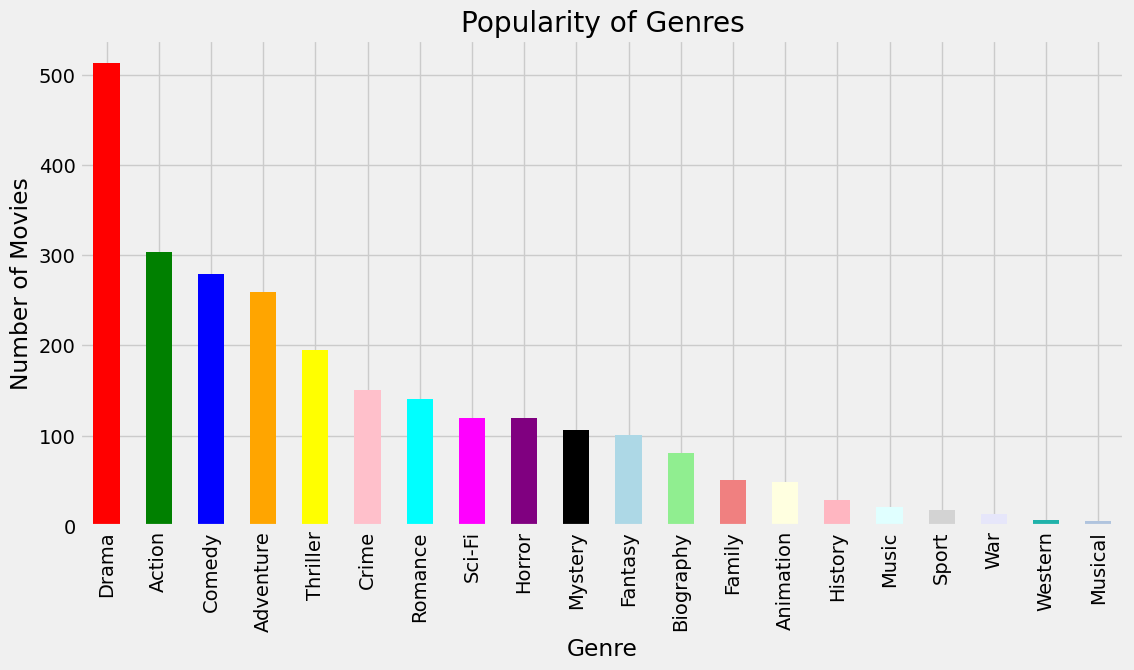

In [112]:
colours = ['red', 'green', 'blue', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'purple', 'black',
          'lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightcyan', 'lightgrey', 'lavender', 'lightseagreen', 'lightsteelblue']
count_of_movies_by_genre.plot.bar(color=colours)
plt.title('Popularity of Genres')
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.show()

In [73]:
# Create df which contains grouping of genres and the movies associated with
# the grouped genres
movies_with_grouped_genres = movies_with_genre.groupby('Genre')
print("Number of movies with particular group of genres :\n")
print(movies_with_grouped_genres.size()[:10])

Number of movies with particular group of genres :

Genre
Action                         2
Action,Adventure               3
Action,Adventure,Biography     2
Action,Adventure,Comedy       14
Action,Adventure,Crime         6
Action,Adventure,Drama        18
Action,Adventure,Family        4
Action,Adventure,Fantasy      27
Action,Adventure,Horror        2
Action,Adventure,Mystery       5
dtype: int64


In [74]:
print("Most Popular Grouped Genres: \n")
print(movies_with_grouped_genres.size().sort_values(ascending = False)[:10])

Most Popular Grouped Genres: 

Genre
Action,Adventure,Sci-Fi       50
Drama                         48
Comedy,Drama,Romance          35
Comedy                        32
Drama,Romance                 31
Action,Adventure,Fantasy      27
Comedy,Drama                  27
Animation,Adventure,Comedy    27
Comedy,Romance                26
Crime,Drama,Thriller          24
dtype: int64


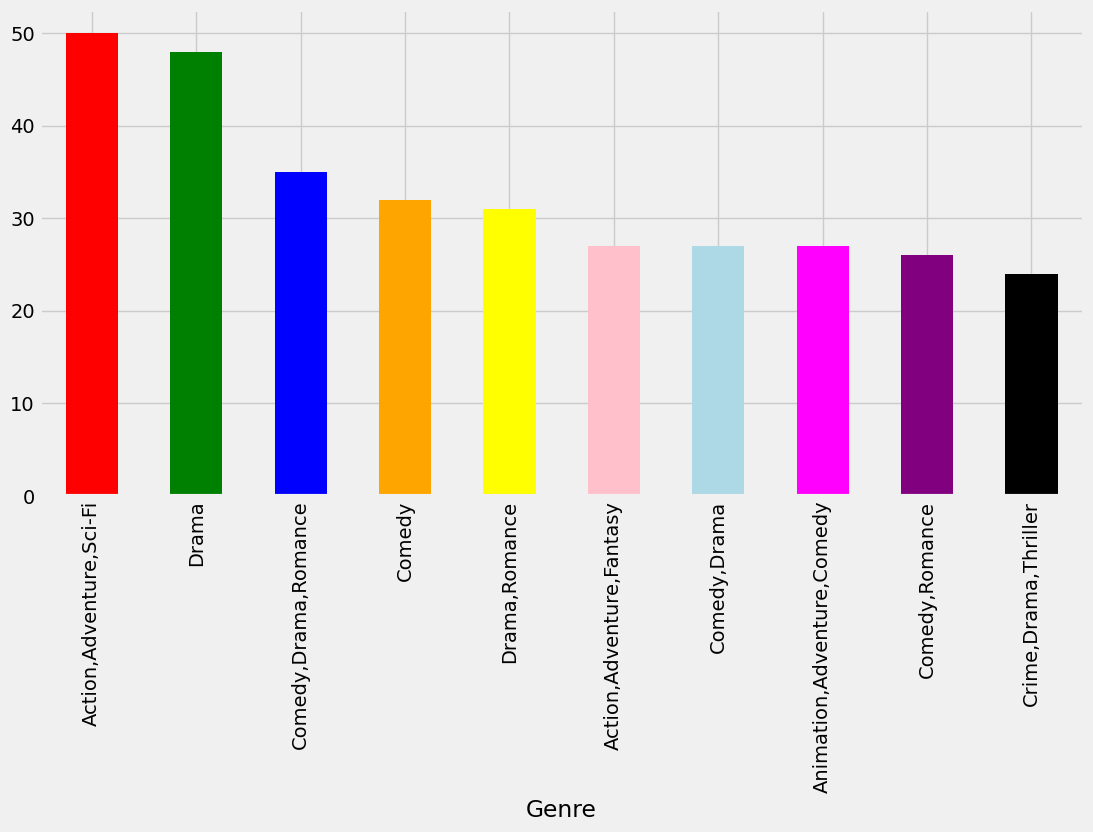

In [90]:
colours = ['red', 'green', 'blue', 'orange','yellow','pink','lightblue','Magenta','purple','black']
most_pop = (movies_with_grouped_genres.size().sort_values(ascending = False)[:10])
most_pop.plot(kind='bar',color=colours)
plt.show()

Based on Actors (popularity, views and votes)

In [76]:
# df of movies for which Actors info is present
movies_with_Actors = data[data['Actors'].isnull() == False]
# no of movies for which Actors info is present
movies_with_Actors.shape[0]

1000

In [77]:
unique_Actors = set()
for Actors in movies_with_Actors['Actors'].str.split(","):
    for act in Actors:
        unique_Actors.add(act)
# display
print("Number of Unique Stars : {}".format(len(unique_Actors)))

Number of Unique Stars : 2394


In [78]:
# Group movies by Actors

movies_by_act = dict()

# Creating a dictionary of movies accessed by act
for act in unique_Actors:
    movies_by_act[act] = movies_with_Actors[movies_with_Actors['Actors'].apply(lambda x: act in x )]

In [79]:
# Create a dictionary mapping of act and number of movies
# that the actor acted in
count_of_movies_by_act = dict()

for act in unique_Actors:
    count_of_movies_by_act[act] = movies_by_act[act]['Title'].count()

count_of_movies_by_act = pd.Series(count_of_movies_by_act).sort_values(ascending=False)

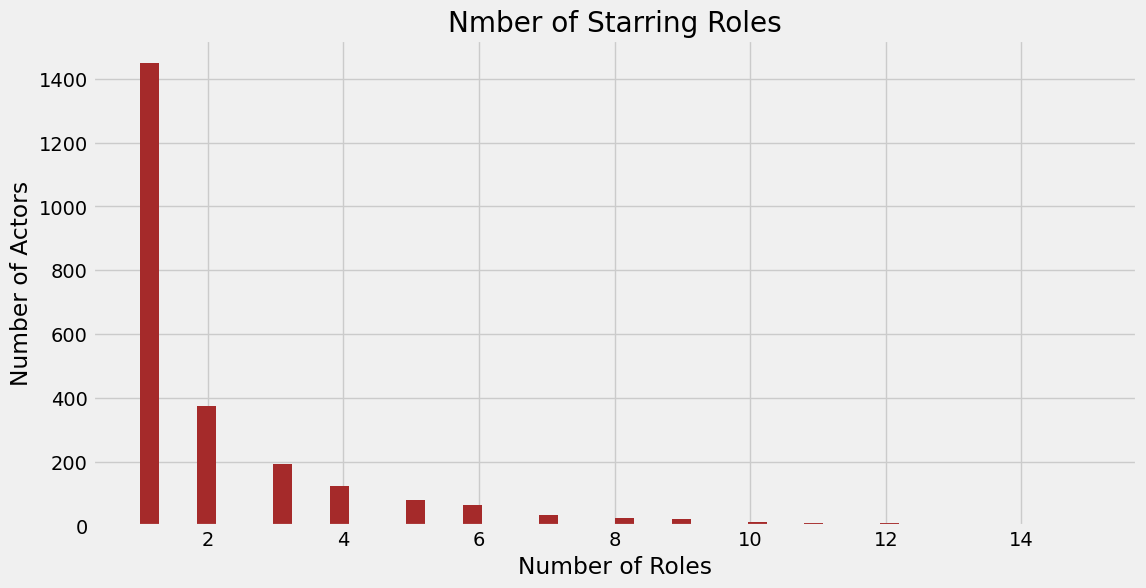

In [108]:
# Histogram of number of starring roles
plt.hist(count_of_movies_by_act, bins=50,color='brown')
plt.title('Nmber of Starring Roles')
plt.ylabel('Number of Actors')
plt.xlabel('Number of Roles')
plt.show()

In [81]:
# The 20 most featured actors
print("Number of movies by each star (top 20)")
count_of_movies_by_act[:20]

Number of movies by each star (top 20)


Mark Wahlberg         15
Hugh Jackman          14
Christian Bale        13
Brad Pitt             13
Johnny Depp           12
Scarlett Johansson    12
Tom Hardy             12
Anne Hathaway         12
Michael Fassbender    12
Channing Tatum        12
Robert Downey Jr.     12
Cate Blanchett        11
Gerard Butler         11
Jennifer Lawrence     11
Chloë Grace Moretz    11
Seth Rogen            11
Anna Kendrick         11
Jake Gyllenhaal       11
Bradley Cooper        11
Shia LaBeouf          11
dtype: int64

# FACTORS affecting performance of movies
#Can be measured in terms of box-office revenue(Commercial success) and rating(Critical success). Rating is an average rating by users, its not accurate measure of critical success, but it is an indication of the popular opinion of a movie.

Understanding relationship between Gross and Genre.

In [82]:
movies_with_votes= data[data['Votes'].isnull() == False]
# Create a dictionary to store masks for each genre
genre_masks = dict()
for genre in unique_genres:
    genre_masks[genre] = movies_with_votes['Genre'].apply(lambda x: genre in x)

# Dictionary to arrange movies by genre
movies_with_votes_by_genre = dict()

# DataFrame to hold summary stats for Votes for each genre
votes_by_genre = pd.DataFrame(index=count_of_movies_by_genre.index,
                              columns=['Total', 'Mean', 'Median', 'STD'])

# Populate dictionary and DataFrame with values
for genre in unique_genres:
    # Filter movies by genre using the masks
    movies_with_votes_by_genre[genre] = movies_with_votes[genre_masks[genre]]

    # Calculate summary statistics for 'Votes'
    votes_by_genre.loc[genre]['Total'] = movies_with_votes_by_genre[genre]['Votes'].sum()
    votes_by_genre.loc[genre]['Mean'] = movies_with_votes_by_genre[genre]['Votes'].mean()
    votes_by_genre.loc[genre]['Median'] = movies_with_votes_by_genre[genre]['Votes'].median()
    votes_by_genre.loc[genre]['STD'] = movies_with_votes_by_genre[genre]['Votes'].std()


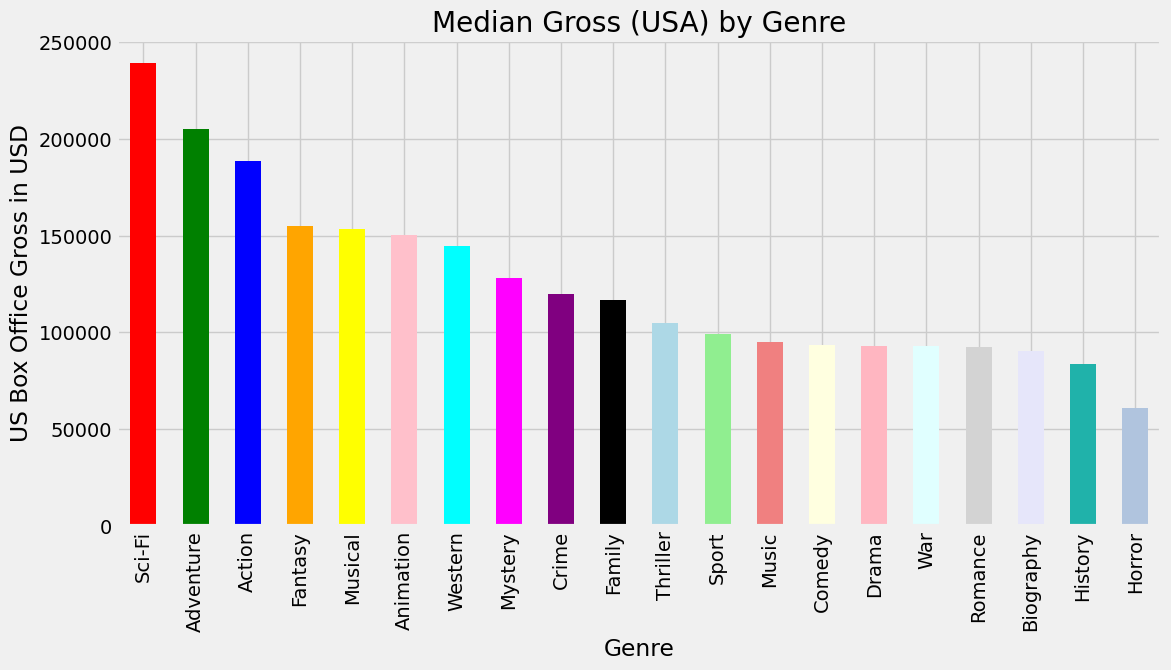

In [110]:
# Plot of Median US Gross by Genre
colours=['red', 'green', 'blue', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'purple', 'black',
          'lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightcyan', 'lightgrey', 'lavender', 'lightseagreen', 'lightsteelblue']
votes_by_genre['Median'].sort_values(ascending=False).plot.bar(color=colours)
plt.title('Median Gross (USA) by Genre')
plt.xlabel('Genre')
plt.ylabel('US Box Office Gross in USD')
plt.show()

# Relationship between Rating and Gross
Whether a high rating movie earns high in box office? Or a low rating movie earns a high in box office?

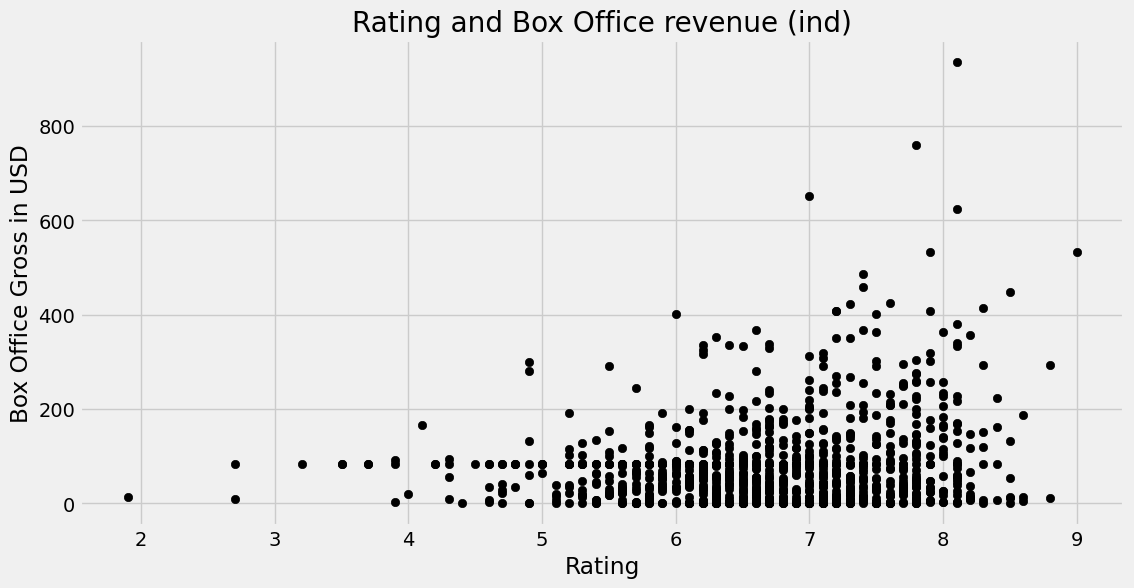

In [113]:
# movies_with_votes already contains set of movies with both box office figures and rating
plt.scatter(movies_with_votes['Rating'], movies_with_votes['Revenue (Millions)'],color='black')
plt.title('Rating and Box Office revenue (ind)')
plt.xlabel('Rating')
plt.ylabel('Box Office Gross in USD')
plt.show()

CORRELATION ANALYSIS BASED ON TOP 5 FEATURES

In [36]:
numerical_columns = ['Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore']

# Compute the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Find the top 5 features correlated with 'Rating'
top_correlated_features = correlation_matrix['Rating'].sort_values(ascending=False)[1:6]

print("Top 5 features correlated with 'Rating':")
print(top_correlated_features)

Top 5 features correlated with 'Rating':
Metascore             0.631897
Votes                 0.511537
Runtime (Minutes)     0.392214
Revenue (Millions)    0.217654
Year                 -0.211219
Name: Rating, dtype: float64


FEATURE SUBSET SELECTION

In [38]:

# Select only numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Set the threshold for correlation coefficient
threshold = 0.5

# Create a mask to identify highly correlated features
mask = (correlation_matrix.abs() >= threshold) & (correlation_matrix.abs() < 1.0)

# Identify columns to drop
columns_to_drop = set()
for col in mask.columns:
    correlated_columns = mask[col][mask[col]].index.tolist()
    columns_to_drop.update(set(correlated_columns) - {col})

# Drop highly correlated columns
selected_features = data.drop(columns=columns_to_drop)

#selected_features.head()

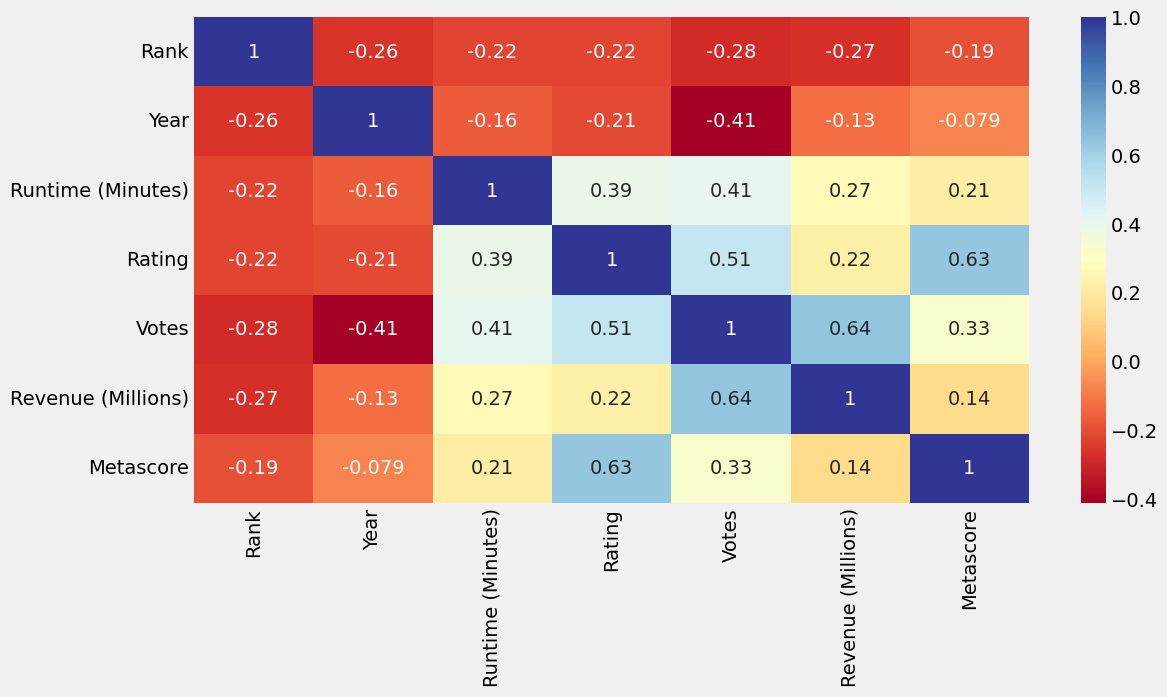

In [39]:
cor=data[numerical_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.RdYlBu)
plt.show()
print("Strength of Correlation: The intensity of colors in the heatmap indicates the strength of correlation between pairs of numerical features. Dark blue represents strong positive correlation, while dark red represents strong negative correlation. Lighter colors signify weaker correlations or no correlation.")


From the above matrix , we can conclude that :
**Positive Correlation (Dark Blue)**:we might observe a positive correlation between "Revenue (Millions)" and "Votes", suggesting that movies with higher revenue tend to have more votes.

**Negative Correlation (Dark Red)**:we might observe a negative correlation between "Year" and "Votes", suggesting that older movies tend to have lower Votes.

PREDICTION REGRESSION MODEL BASED ON R-SQUARED TEST

Mean Squared Error: 0.4498570549517318
R-squared: 0.530696901874333


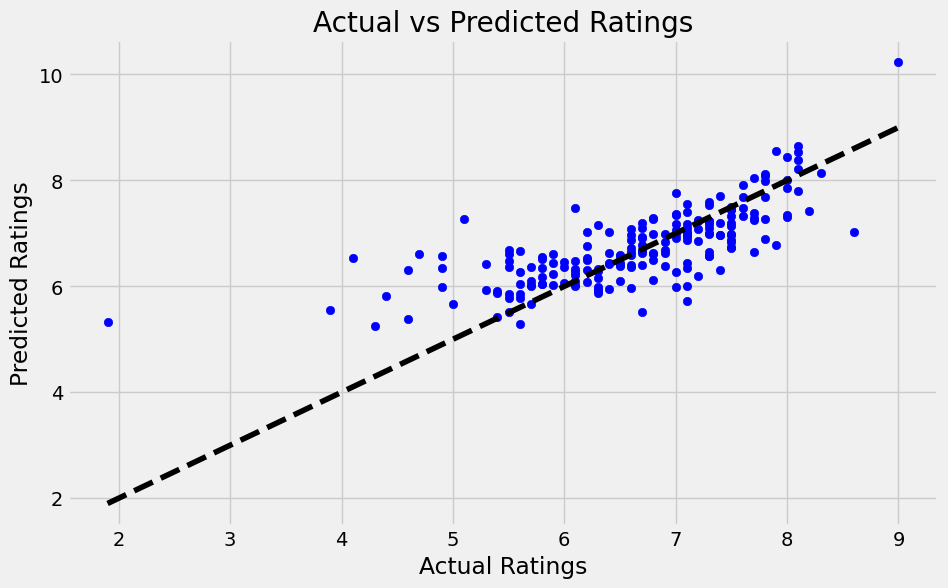

In [52]:


# Select relevant features and target variable
X = data[['Year', 'Runtime (Minutes)', 'Votes', 'Revenue (Millions)', 'Metascore']]
y = data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predicted ratings vs actual ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()
